### Подгрузка всех необходимых библиотек

In [273]:
# База
import re
import time
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
# Работа с NLP
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('universal_tagset')

### Dataset и его описание

Для анализа были взяты лишь 20% данных, чтобы на перенагружать систему. Данные были засемплированы с учетом пропорций токсичных комментариев в выборке. Для этого была создана дополнительный столбец `toxic`, значения которой равны 1, если значения столбца `target` => 0.5, что соотвествует описанию из соревнования Kaggle.

In [277]:
#df = pd.read_csv('train 2.csv')
#df['toxic'] = (df['target'] >= 0.5).astype(int)
#grouped = df.groupby('toxic')
#sampled_df = grouped.apply(lambda x: x.sample(frac=0.2, random_state=42)).reset_index(drop=True)
#sampled_df.to_csv('strain_data.csv')
df = pd.read_csv('strain_data.csv', index_col=0)

In [278]:
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,toxic
0,814517,0.0,".\n\nThe next time you buy a car, all things b...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,2,0,0,10,0,0.0,0,4,0
1,748137,0.0,I don't trust Nanos Polling.,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,9,0,0.0,0,4,0
2,5664789,0.0,Police took the woman's version that the 70 y....,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,1,0,0.0,4,4,0
3,963601,0.0,The study found that between 2-8% of assault c...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,4,0,0.0,0,4,0
4,4996776,0.0,Seems most of the new jobs are part time so th...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,3,0,0.0,0,4,0


##### Основные переменные:
- `coment_text` - комментарий
- `target` - уровень токсичности комментария (комментарий считается токсичным при значениях >= 0.5)
- `toxic` - бинарная переменная, которая указывает на токсичность комментария

##### Дополнительные переменные отражающие уровни пренадлежности к подтипам токсичных комментариев

- `severe_toxicity` - высокая токсичность
- `obscene` - нецензурность/непристойность
- `threat` - угроза
- `insult` - оскорбление
- `identity_attack` - нападение на личность
- `sexual_explicit` - откровенно сексуальный

##### Дополнительные переменные отражающие упомянутые личностные атрибуты в комментарии:

- `male`
- `female`
- `transgender`
- `other_gender`
- `heterosexual`
- `homosexual_gay_or_lesbian`
- `bisexual`
- `other_sexual_orientation`
- `christian`
- `jewish`
- `muslim`
- `hindu`
- `buddhist`
- `atheist`
- `other_religion`
- `black`
- `white`
- `asian`
- `latino`
- `other_race_or_ethnicity`
- `physical_disability`
- `intellectual_or_learning_disability`
- `psychiatric_or_mental_illness`
- `other_disability`

#### Метаданные

- `toxicity_annotator_count`
- `identity_annotator_count`
- `created_date`
- `publication_id`
- `parent_id`
- `article_id`
- `rating`  - это оценка цивилизованности, которую пользователи Civil Comments поставили комментарию.
- `funny`
- `wow`
- `sad`
- `likes`
- `disagree`

In [282]:
df.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'toxic'],
      dtype='object')

In [284]:
mc = ['target', 'comment_text','toxic']

atc = ['severe_toxicity','obscene',
       'identity_attack','insult','threat',
       'sexual_explicit']

ic = ['asian','atheist','bisexual',
      'black','buddhist','christian',
      'female','heterosexual','hindu',
      'homosexual_gay_or_lesbian',
      'intellectual_or_learning_disability',
      'jewish','latino','male','muslim',
      'other_disability','other_gender',
      'other_race_or_ethnicity','other_religion',
      'other_sexual_orientation','physical_disability',
      'psychiatric_or_mental_illness','transgender','white']

comc = ['created_date', 'publication_id',
        'parent_id','article_id','rating',
        'funny','wow','sad','likes','disagree']

amc = ['toxicity_annotator_count',
       'identity_annotator_count']


In [286]:
df.info(show_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 360975 entries, 0 to 360974
Data columns (total 46 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   id                                   360975 non-null  int64  
 1   target                               360975 non-null  float64
 2   comment_text                         360974 non-null  object 
 3   severe_toxicity                      360975 non-null  float64
 4   obscene                              360975 non-null  float64
 5   identity_attack                      360975 non-null  float64
 6   insult                               360975 non-null  float64
 7   threat                               360975 non-null  float64
 8   asian                                81374 non-null   float64
 9   atheist                              81374 non-null   float64
 10  bisexual                             81374 non-null   float64
 11  black             

In [288]:
# привел колонку с датами к правильному формату
df.created_date = pd.to_datetime(df.created_date, utc=True, format="ISO8601")

### Базовый анализ

Описательные статистики для числовых переменных

In [292]:
df[mc].describe()

,target,toxic
count,360975.000000,360975.000000
mean,0.103296,0.079970
std,0.197306,0.271246
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.166667,0.000000
max,1.000000,1.000000


In [294]:
df[atc].describe()

,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
count,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000
mean,0.004535,0.013818,0.022749,0.081335,0.009355,0.006620
std,0.022807,0.064277,0.078836,0.176437,0.049688,0.045325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000
max,0.644363,1.000000,1.000000,1.000000,1.000000,1.000000


In [296]:
df[ic].describe()

,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,...,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white
count,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,...,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000,81374.000000
mean,0.012428,0.003229,0.001998,0.033600,0.001330,0.094835,0.127301,0.003263,0.001446,0.025769,...,0.049381,0.001212,0.000907,0.008360,0.006834,0.001519,0.001451,0.012023,0.006790,0.056779
std,0.089858,0.050968,0.027330,0.166079,0.029793,0.255863,0.305269,0.046008,0.030784,0.144068,...,0.202078,0.013869,0.012235,0.043497,0.037475,0.015473,0.018675,0.088596,0.069366,0.215231
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.500000,0.750000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000


In [298]:
df[comc].describe()

,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree
count,360975.000000,2.056880e+05,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000
mean,49.899694,3.734685e+06,281628.753396,0.277454,0.044341,0.108936,2.451893,0.584727
std,27.698607,2.447379e+06,103851.964874,1.047562,0.247155,0.455586,4.744377,1.868592
min,2.000000,6.618700e+04,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,8.002055e+05,160211.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,5.226178e+06,332256.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,54.000000,5.778208e+06,366276.500000,0.000000,0.000000,0.000000,3.000000,0.000000
max,111.000000,6.333965e+06,399528.000000,58.000000,21.000000,30.000000,182.000000,95.000000


In [300]:
df[amc].describe()

,toxicity_annotator_count,identity_annotator_count
count,360975.000000,360975.000000
mean,8.765809,1.455860
std,42.829416,18.499978
min,3.000000,0.000000
25%,4.000000,0.000000
50%,4.000000,0.000000
75%,6.000000,0.000000
max,3509.000000,1866.000000


##### N/a и дубликаты

In [303]:
#Рассмотрим поподробнее в каких колонках в датасете имеются Na значения
df.isna().sum()

id                                          0
target                                      0
comment_text                                1
severe_toxicity                             0
obscene                                     0
identity_attack                             0
insult                                      0
threat                                      0
asian                                  279601
atheist                                279601
bisexual                               279601
black                                  279601
buddhist                               279601
christian                              279601
female                                 279601
heterosexual                           279601
hindu                                  279601
homosexual_gay_or_lesbian              279601
intellectual_or_learning_disability    279601
jewish                                 279601
latino                                 279601
male                              

Как можно заметить в основном N/a встречаются в дополнительных переменных отражающих упомянутые личностные атрибуты в комментарии, а также в переменной `parent_id`. Также имеется одно значение в текстах комментариев. Строка с пропущенным значением комментарием будет также удалена, а пропущенные атрибуты и  `parent_id` лучше еще проанализировать.

In [306]:
df.dropna(subset=['comment_text'], inplace=True)

In [314]:
df[~df.asian.isna()].created_date.dt.year.value_counts()

created_date
2017    62098
2016    19251
2015       24
Name: count, dtype: int64

In [316]:
df[df.asian.isna()].created_date.dt.year.value_counts()

created_date
2017    212394
2016     67086
2015       121
Name: count, dtype: int64

Я подумал, что может быть дело в дате создания определенного комментария, но это похоже не совсем так. Не совсем понятно стоит ли данные атрибуты применять в дальнейшей работе, так как примерно лишь 22% перемнных связанными с атрибутами хранят в себе нормальные значения в невыборочном датасете.

Рассмотрим теперь дубликаты

In [327]:
df[df.toxic == 1].comment_text.duplicated().sum()

103

In [331]:
df[df.toxic == 0].comment_text.duplicated().sum()

2108

In [333]:
df[df.toxic == 0].comment_text.value_counts()[:10]

comment_text
Exactly.                                                                                                                                                                                                                                                                                                                                                             37
Well said.                                                                                                                                                                                                                                                                                                                                                           35
No.                                                                                                                                                                                                                                                                        

In [329]:
df[df.toxic == 1].comment_text.value_counts()[:10]

comment_text
Pathetic.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             7
You're an idiot.                                                                                                                                                                                                   

На текущий момент наверное просто стоит избавиться от дубликатов датасете и оставить по одному значению. Однако стоит отметить, что в обычных комменатриях довольно часто попадается рассылка с рекламой скама. Не совсем понятно стоит ли отставлять ее в рассмотрении или нет. В целом у нас довольно много данных и скорее всего данная рассылка никак не повлияет на результат.

In [338]:
df.drop_duplicates(subset=['comment_text'], inplace=True)

##### Анализ длины комментариев

In [44]:
# Функций создающая графики
df['comm_length'] = df['comment_text'].fillna("").apply(len)

def hist_len(data, title):
    median_length = data['comm_length'].median()
    mean_length = data['comm_length'].mean()
    min_length = data['comm_length'].min()
    max_length = data['comm_length'].max()

    plt.figure(figsize=(10, 6))
    plt.hist(data['comm_length'], bins=50, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Длина текста (символы)')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

    print(f'Средняя длина комментария: {mean_length}')
    print(f'Медианная длина комментария: {median_length}')
    print(f'Минимальная длина комментария: {min_length}')
    print(f'Максимальная длина комментария: {max_length}')

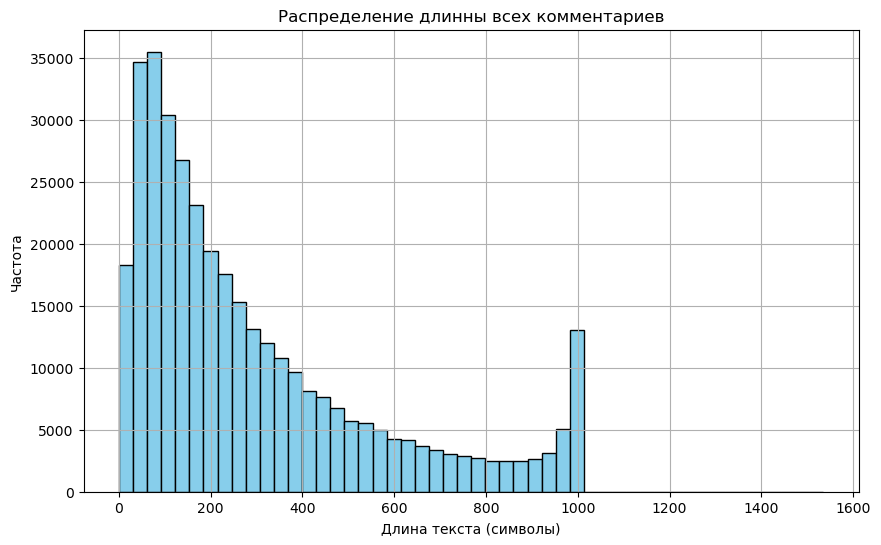

Средняя длина комментария: 296.9542018145301
Медианная длина комментария: 202.0
Минимальная длина комментария: 0
Максимальная длина комментария: 1535


In [46]:
hist_len(df, 'Распределение длинны всех комментариев')

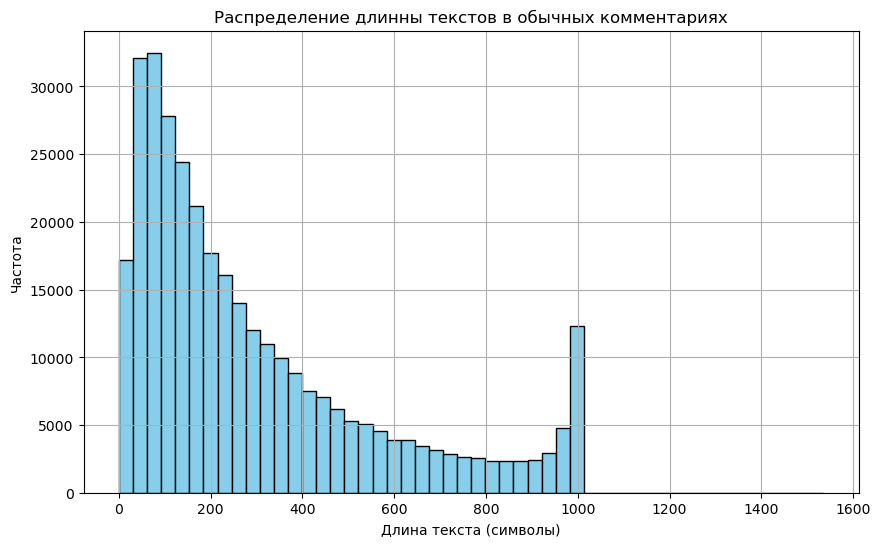

Средняя длина комментария: 298.72511953942694
Медианная длина комментария: 203.0
Минимальная длина комментария: 0
Максимальная длина комментария: 1535


In [48]:
hist_len(df[df.toxic == 0], 'Распределение длинны текстов в обычных комментариях')

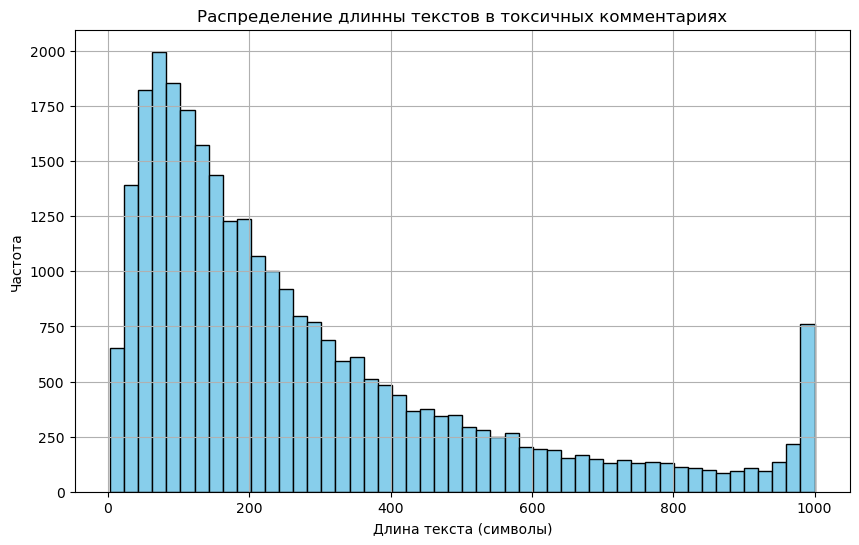

Средняя длина комментария: 276.5802126996224
Медианная длина комментария: 194.0
Минимальная длина комментария: 3
Максимальная длина комментария: 1000


In [50]:
hist_len(df[df.toxic == 1], 'Распределение длинны текстов в токсичных комментариях')

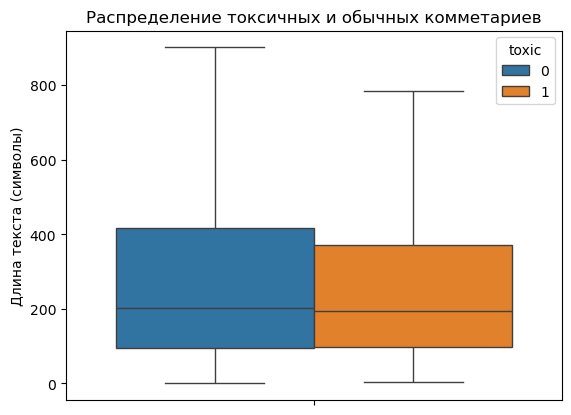

In [52]:
sns.boxplot(data=df, y = 'comm_length', hue = 'toxic', showfliers=False)
plt.title('Распределение токсичных и обычных комметариев')
plt.ylabel('Длина текста (символы)')
plt.show()

Как можно заметить распределение длины комментариев не сильно отличается между токсичными и обычными комментариями

##### Анализ реакций с разделением на токсичные и обычные комментарии

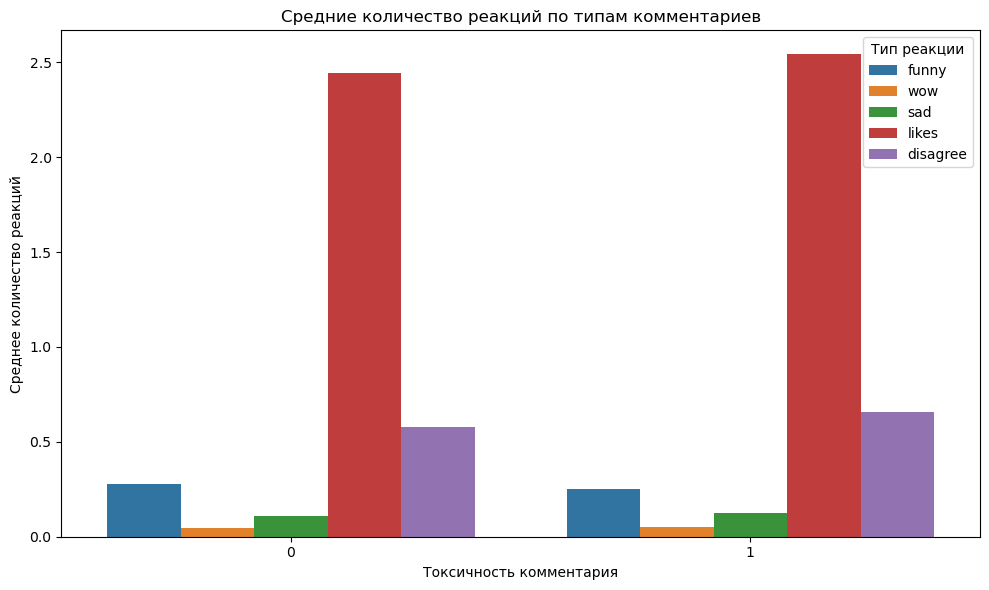

In [117]:
res = df.groupby('toxic')[['funny','wow','sad','likes','disagree']].mean().reset_index()
res = res.melt(
    id_vars='toxic',
    value_vars = ['funny','wow','sad','likes','disagree'],
    var_name = 'Тип реакции',
    value_name = 'Среднее значение'
)
plt.figure(figsize=(10, 6))
sns.barplot(data=res, x='toxic', y='Среднее значение', hue='Тип реакции')

plt.title('Средние количество реакций по типам комментариев')
plt.xlabel('Токсичность комментария')
plt.ylabel('Среднее количество реакций')

# Показать график
plt.tight_layout()
plt.show()

в целом разницы особо нет. Однако в среднем лайков и дизлайков у токсичных комментариев слегка больше. Но по медианным значениям обычно любые комментарии особо не получают реакций

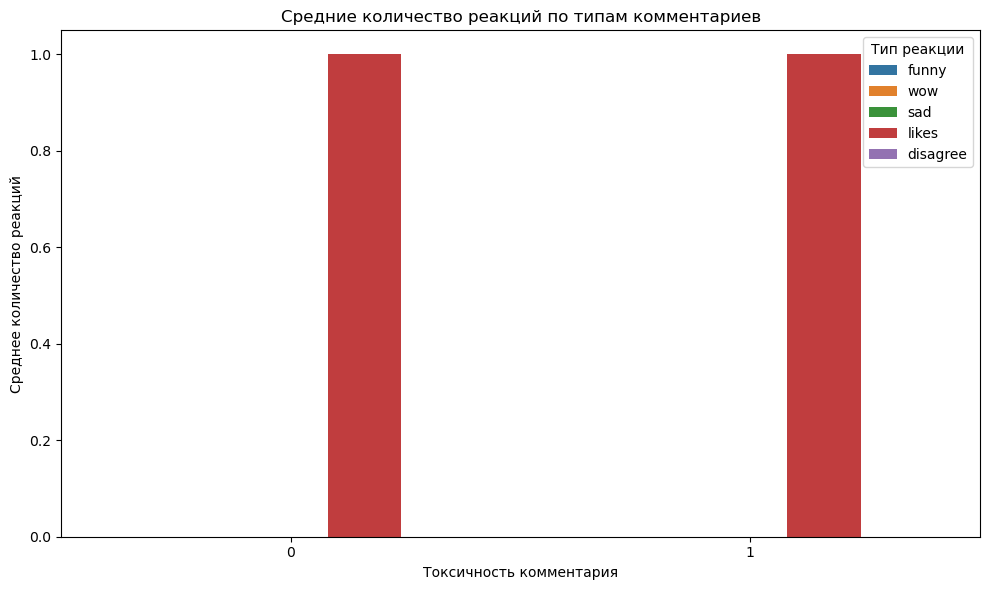

In [235]:
res = df.groupby('toxic')[['funny','wow','sad','likes','disagree']].median().reset_index()
res = res.melt(
    id_vars='toxic',
    value_vars = ['funny','wow','sad','likes','disagree'],
    var_name = 'Тип реакции',
    value_name = 'Медианное значение'
)
plt.figure(figsize=(10, 6))
sns.barplot(data=res, x='toxic', y='Медианное значение', hue='Тип реакции')

plt.title('Средние количество реакций по типам комментариев')
plt.xlabel('Токсичность комментария')
plt.ylabel('Среднее количество реакций')

# Показать график
plt.tight_layout()
plt.show()

##### Количество комментариев по датам

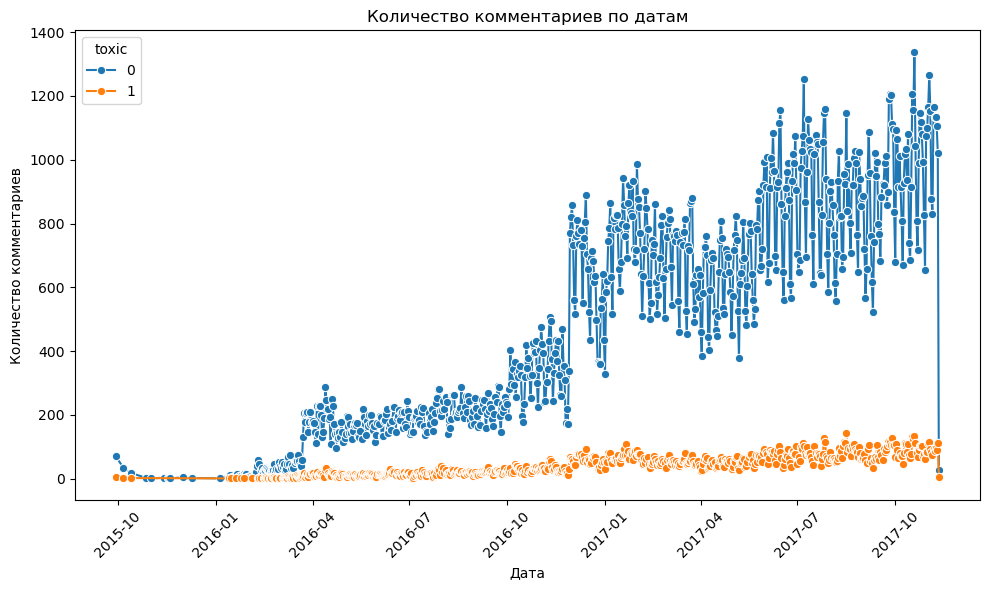

In [243]:
df['date'] = df.created_date.dt.date
res = df[['toxic','date']].groupby(['date','toxic']).size().reset_index(name='qty')

plt.figure(figsize=(10, 6))
sns.lineplot(data=res, x='date', y='qty', hue='toxic', marker="o")

plt.title('Количество комментариев по датам')
plt.xlabel('Дата')
plt.ylabel('Количество комментариев')
plt.xticks(rotation=45)

# Показать график
plt.tight_layout()
plt.show()

Я также хотел нарисовать график с помесячными данными, но что-то пошло не так.  не смог решить проблему, которая не давала его нарисовать. Поэтому я вывел просто статистику по токсичным и обычным комментариям.

In [249]:
df['month_year'] = df.created_date.dt.to_period('M')
res = df[['toxic','month_year']].groupby(['month_year','toxic']).size().reset_index(name='qty')
res.head(10) #Первые 10 значений для примера

/var/folders/2_/v0zbbryd5nl_rj_zp5vsx3200000gn/T/ipykernel_3236/3540438074.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df.created_date.dt.to_period('M')


,month_year,toxic,qty
0,2015-09,0,70
1,2015-09,1,4
2,2015-10,0,55
3,2015-10,1,3
4,2015-11,0,7
5,2015-12,0,6
6,2016-01,0,133
7,2016-01,1,9
8,2016-02,0,724
9,2016-02,1,34


##### Анализ подтипов токсичности

In [367]:
df[df.toxic == 1][atc].median().sort_values().to_frame()

,0
severe_toxicity,0.000000
threat,0.000000
sexual_explicit,0.000000
identity_attack,0.016129
obscene,0.039216
insult,0.581081


Как можно заметить по медианным значениям уровня токсичности комментариев для отдельных подтипов токсичности. Наиболее часто встречающийся тип токсичности это оскорбления.

### Работа с текстом

In [414]:
def r_s_c(text):
    # удаление ссылок
    c_t = re.sub(r'(https?://\S+|www\.\S+)' , '', text)
    #удаление лишних символов
    c_text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', ' ', c_t)
    c_text = re.sub(r'\s+', ' ', c_text).strip()
    return c_text
    
def get_wordnet_pos(treebank_tag):
    #Функция для преобразования POS-тегов
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
# Обработка текста и преобразование в токены
def preprocess_text(text):
    # Токенизация
    tokens = nltk.word_tokenize(r_s_c(text.lower()))
    tokens = [word for word in tokens if word not in stop_words]
    # Применение POS-теггинга
    pos_tags = pos_tag(tokens)
    
    # Лемматизация с учётом POS-тегов
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tags]
    
    return tokens

# Возвращение текста из состояние токенов в состояние обычной строки

def tts(token):
    return ' '.join(token)

def pos_tagging(tokens):
    return nltk.pos_tag(tokens, tagset='universal')

In [416]:
start = time.time()
df['tokens'] = df.comment_text.fillna("").apply(preprocess_text)
end = time.time()
print((end - start)/60)

4.726382517814637


In [418]:
df.tokens[:10].apply(tts)[0]

'next time buy car thing equal child community country positive thing consider buy model one company build vehicle country honda gm ford chrysler toyota build car canada contribute economy keep large amount canadian wealth canada someone buy bmw subaru hyundai kia mercedes volvo mazda nissan audi porsche vw jaguar land rover send purchase price vehicle canada never benefit child fellow canadian thing equal buy canadian full disclosure stock automaker family work auto industry'

In [420]:
df.comment_text[0]

'.\n\nThe next time you buy a car, all things being equal, do yourself, your children, your community and your country a positive thing and consider buying a model from one of the companies that build vehicles in your country.\n\nHonda, GM, Ford, Chrysler, Toyota, all build cars in Canada, contributing to our economy and keeping large amounts of Canadian wealth, in Canada\n\nWhen someone buys a BMW, Subaru, Hyundai/KIA, Mercedes, Volvo, Mazda, Nissan, Audi/Porsche, VW, Jaguar, Land Rover, you are sending most of the purchase price of the vehicle out of Canada, never to benefit yourself or your children or your fellow Canadians.\n\nAll things being equal, Buy Canadian.\n\nFull disclosure - I own no stock in any automakers nor do I nor any of my family work in the auto industry.\n\n.'

In [422]:
all_words = [word for tokens in df['tokens'] for word in tokens]
bigrams = [ngram for tokens in df['tokens'] for ngram in ngrams(tokens, 2)]
trigrams = [ngram for tokens in df['tokens'] for ngram in ngrams(tokens, 3)]
awt = [word for tokens in df[df.toxic == 1]['tokens'] for word in tokens]
bt = [ngram for tokens in df[df.toxic == 1]['tokens'] for ngram in ngrams(tokens, 2)]
tt = [ngram for tokens in df[df.toxic == 1]['tokens'] for ngram in ngrams(tokens, 3)]

In [396]:
# функция для построения гистограммы 
def histpltc(d, title, xl, yl, t='w'):
    if t == 'w':
        data = dict(d)
        plt.figure(figsize=(8, 10))
        sns.barplot(y=list(data.keys()), x=list(data.values()))
        plt.xlabel(xl)
        plt.ylabel(yl)
        plt.title(title)
        plt.xticks(rotation=60)
        plt.show()
    else:
        labels = [' '.join(pair) for pair, count in d]
        counts = [count for pair, count in d]
        plt.figure(figsize=(8, 10))
        sns.barplot(y=labels, x=counts)
        plt.xlabel(xl)
        plt.ylabel(yl)
        plt.title(title)
        plt.xticks(rotation=60)
        plt.show()

In [424]:
word_freq = Counter(all_words).most_common(30)
word_freq_t = Counter(awt).most_common(30)
bigram_freq = Counter(bigrams).most_common(30)
bigram_freq_t = Counter(bt).most_common(30)
trigram_freq = Counter(trigrams).most_common(30)
trigram_freq_t = Counter(tt).most_common(30)

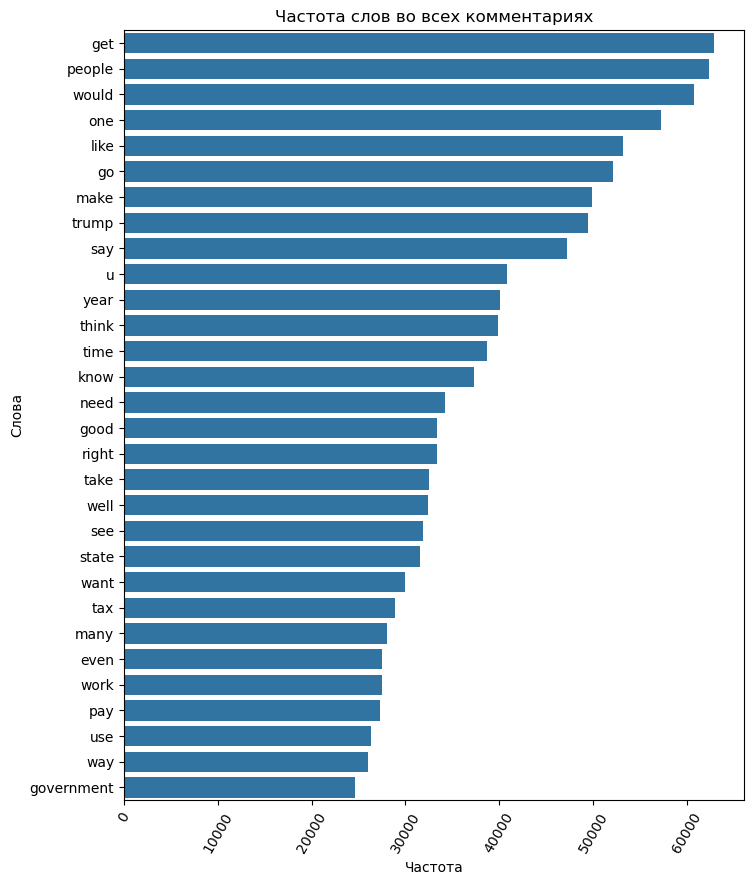

In [426]:
histpltc(word_freq, 'Частота слов во всех комментариях', 'Частота', 'Слова')

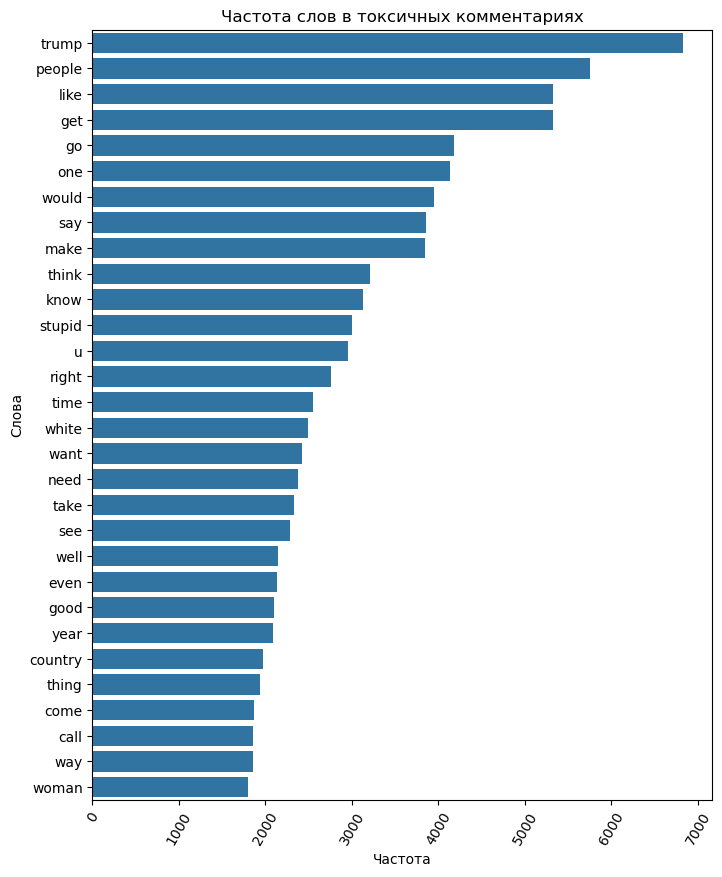

In [428]:
histpltc(word_freq_t, 'Частота слов в токсичных комментариях', 'Частота', 'Слова')

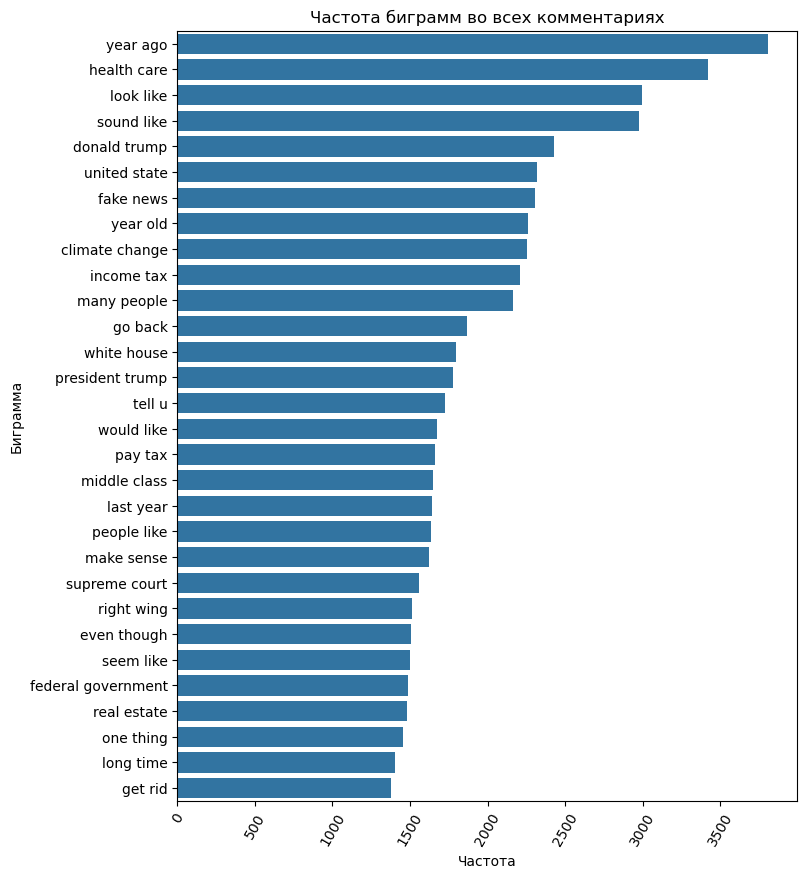

In [430]:
histpltc(bigram_freq, 'Частота биграмм во всех комментариях', 'Частота', 'Биграмма',t='t')

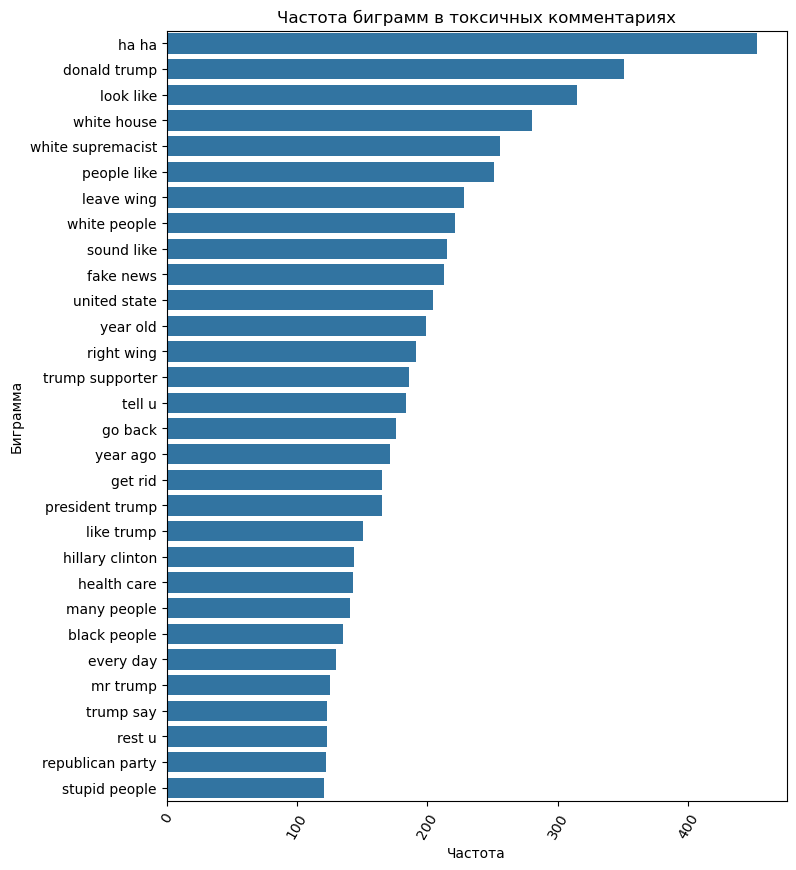

In [432]:
histpltc(bigram_freq_t, 'Частота биграмм в токсичных комментариях', 'Частота', 'Биграмма',t='t')

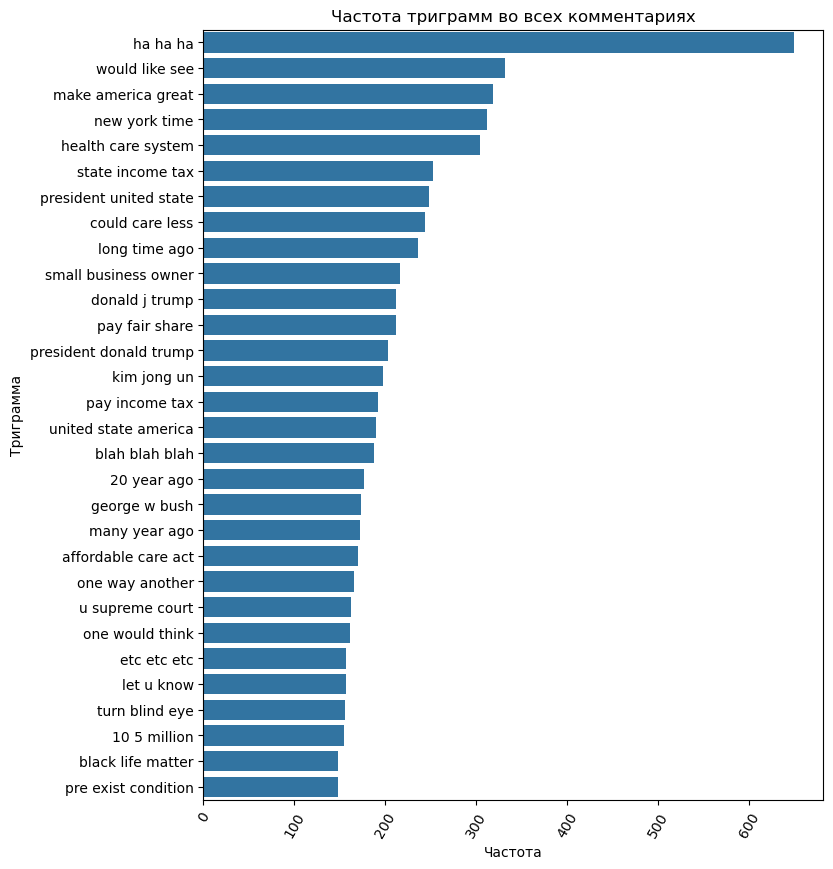

In [434]:
histpltc(trigram_freq, 'Частота триграмм во всех комментариях', 'Частота', 'Триграмма',t='t')

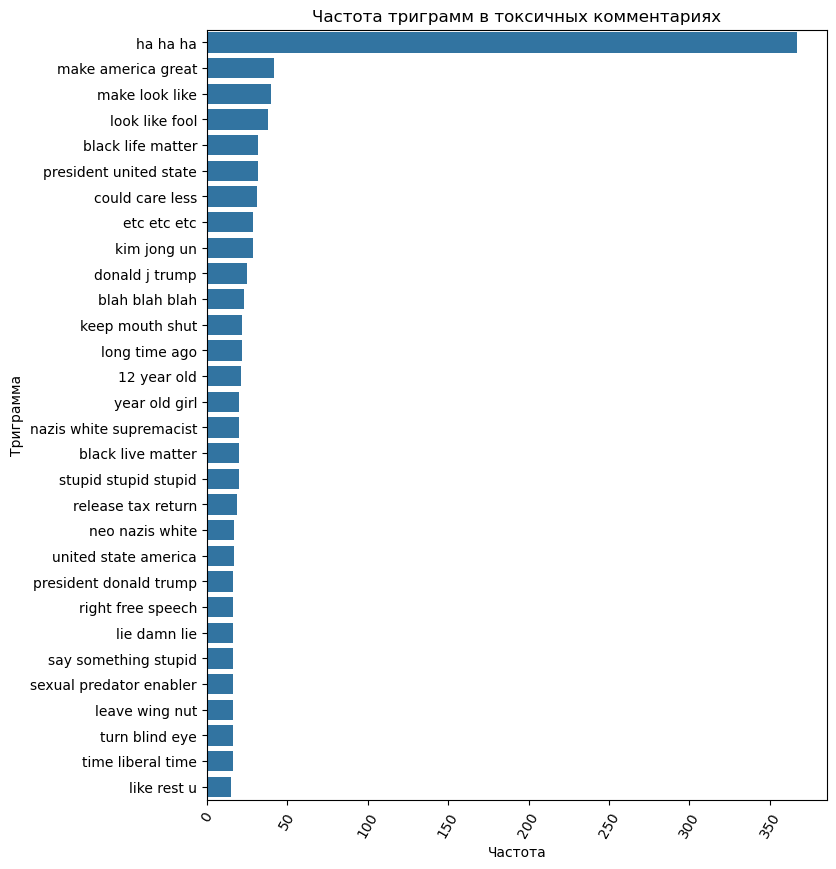

In [436]:
histpltc(trigram_freq_t, 'Частота триграмм в токсичных комментариях', 'Частота', 'Триграмма',t='t')

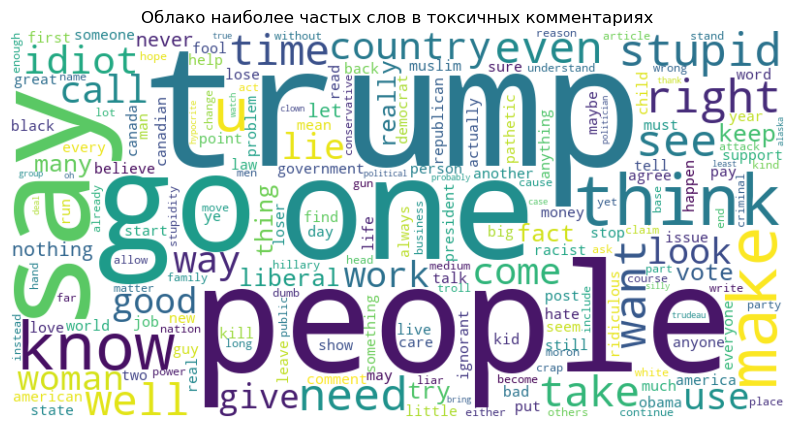

In [438]:
from wordcloud import WordCloud
awt_str = ' '.join(awt)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(awt_str)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако наиболее частых слов в токсичных комментариях')
plt.show()

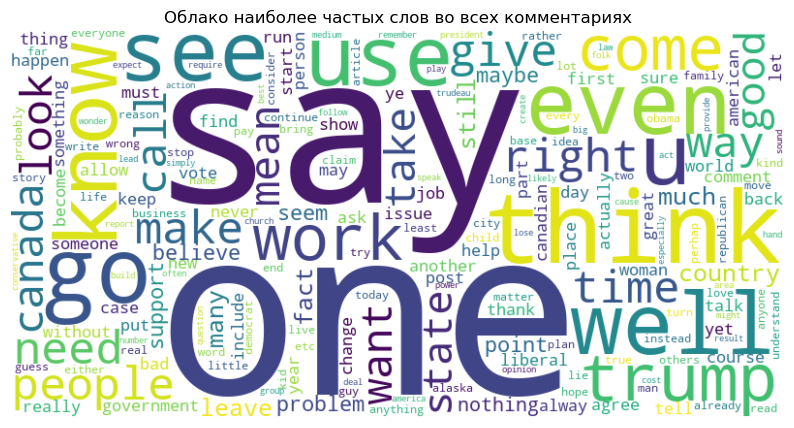

In [440]:
all_words_str = ' '.join(all_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_str)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако наиболее частых слов во всех комментариях')
plt.show()

In [444]:
start = time.time()

sample_texts = df['tokens'].apply(pos_tagging)
all_sample_pos_tags = [tag for tags in sample_texts for _, tag in tags]

end = time.time()
print((end - start)/60)

3.9500428318977354


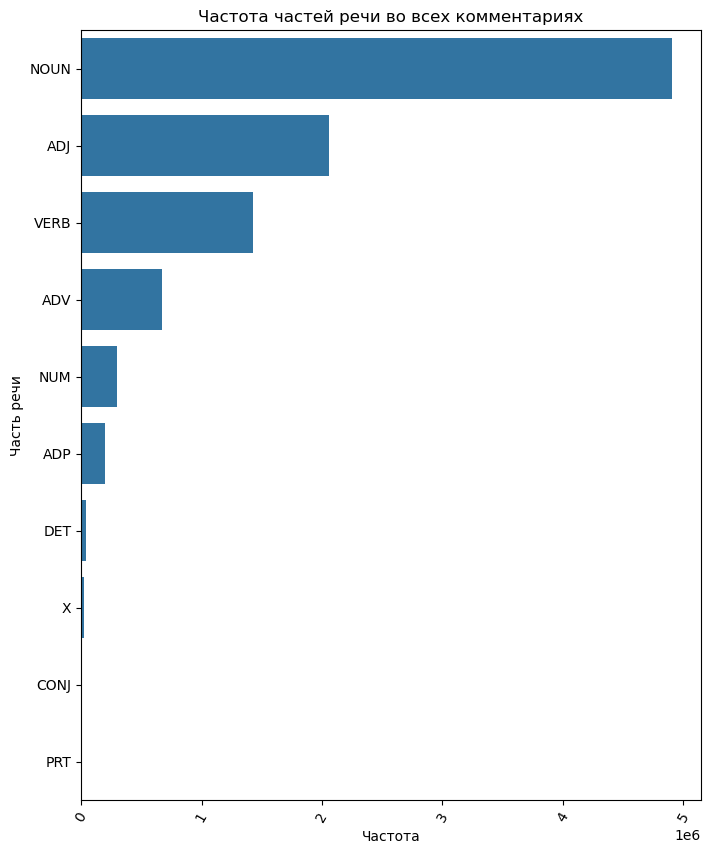

In [446]:
pos_freq_sample = Counter(all_sample_pos_tags).most_common(10)
histpltc(pos_freq_sample, 'Частота частей речи во всех комментариях', 'Частота', 'Часть речи')

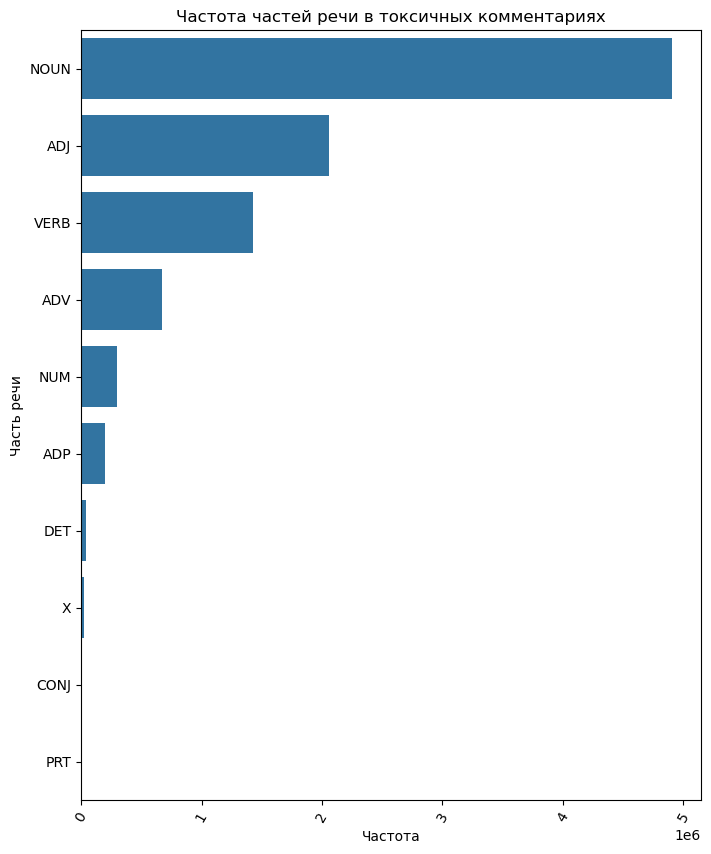

In [448]:
stt = sample_texts[df.toxic == 1]
all_sample_pos_tags_t = [tag for tags in stt for _, tag in tags]
pos_freq_sample_t = Counter(all_sample_pos_tags_t).most_common(10)
histpltc(pos_freq_sample, 'Частота частей речи в токсичных комментариях', 'Частота', 'Часть речи')